#  Taxi orders prediction

# Project goal:

Analyse the taxi orders time series data and build a model that will predict the number of taxi orders for the next hour.\
This model will be used by the taxi operator to be ready for the peak loads.

# Project plan

- Get familiar with the data: info, describe
- Analyse the time series trends and seasonality if it is present. Plot some charts to show the findings.
- Build the ML models to maximize RMSE. Try Linear regression, random forest and LGBM regressor
- Compare the results
- Using conclusions from the previous step try to improve performance by feature engineering and parameter tuning
- Compare results of the original and tuned models. Select the best one. 

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

import seaborn as sns
#sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor

# First look at the data

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data.sort_index(inplace=True)

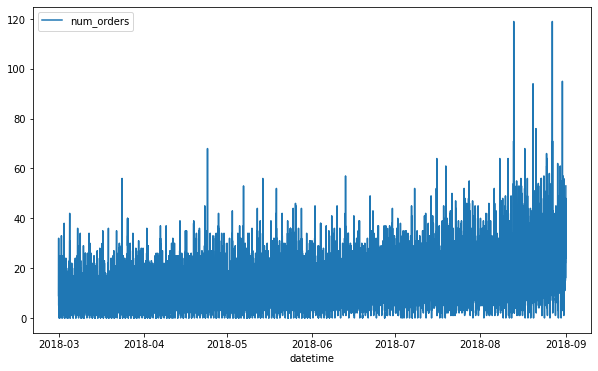

In [7]:
sns.lineplot(data=data)
plt.show()

Since the task requires to predict peak loads, I will use hourly resampling and look for the max load.

This will allow the model to predict exactly what the "client" asks for — max hourly demand for the taxi.

In [8]:
data = data.resample('1H').sum()

In [9]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Data exploration

In [10]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


The data covers the period from March 1, 2018 to August 31, 2018

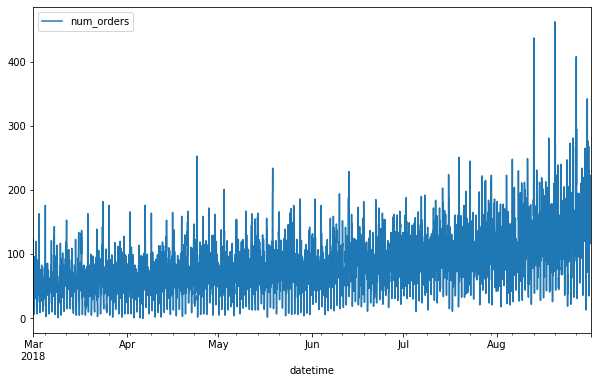

In [11]:
data.plot()
plt.show()

The graph shows that the most active days with the highest number of orders per hour were in August

Let's take a look at the rolling mean to see if there is any pattern to this data

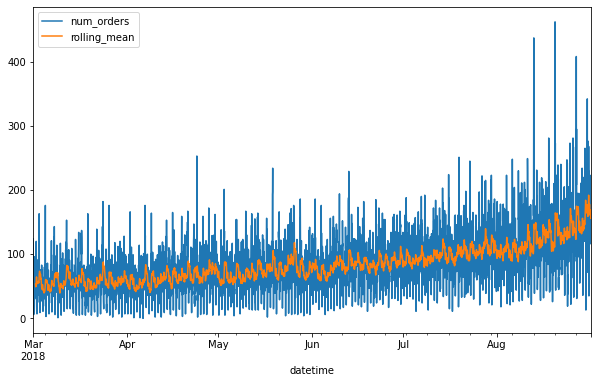

In [12]:
data['rolling_mean'] = data.rolling(20).mean()
data.plot()
plt.show()

The number of orders seems to be rising throught 2018

Let's check if there is seasonal trend to this data

In [13]:
data.head()

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN


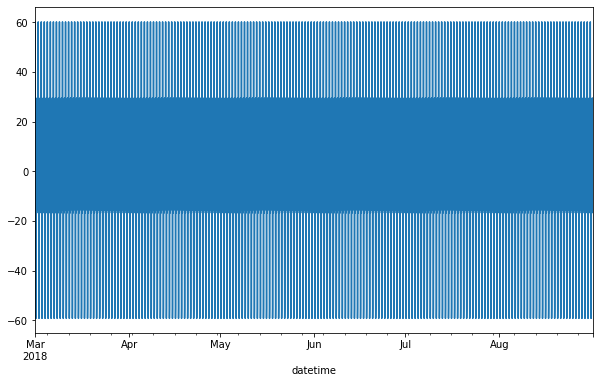

In [14]:
decomposed = seasonal_decompose(data.drop('rolling_mean', axis = 1))
decomposed.seasonal.plot()
plt.show()

Can't see the seasonality on this time interval.\
Let's take a look at a smaller time interval and see if we can find anything 

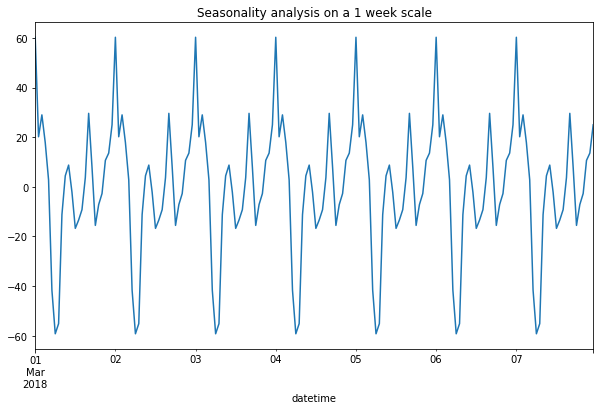

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot()
plt.title('Seasonality analysis on a 1 week scale')
plt.show()

Seems like there is a pattern to the data on a daily interval.\
Let's take a closer look.

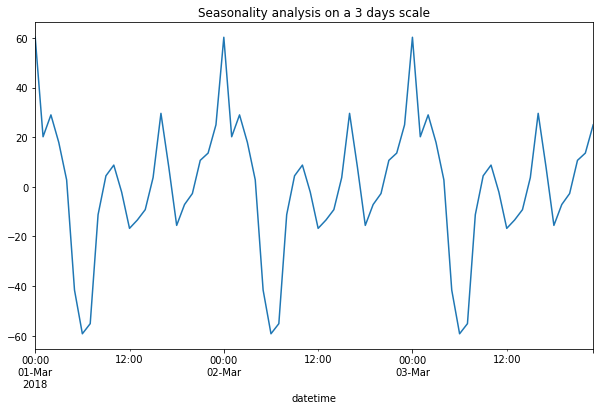

In [16]:
decomposed.seasonal['2018-03-01':'2018-03-03'].plot()
plt.title('Seasonality analysis on a 3 days scale')
plt.show()

As the interval decreases it becomes noticeable that seasonality is present at the daily level. 

The number of orders reaches it's maximum near midnight and a minimum in the early morning at about 6 AM.

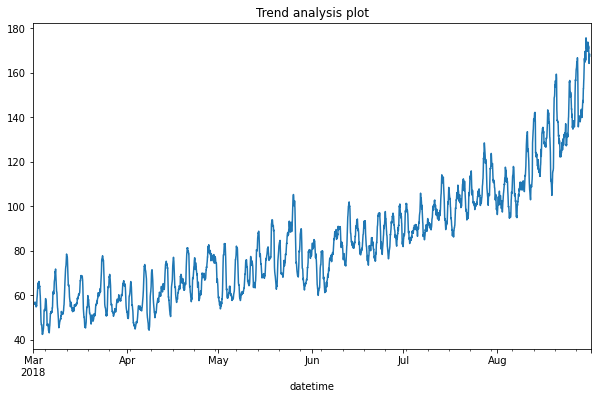

In [17]:
decomposed.trend.plot()
plt.title('Trend analysis plot')
plt.show()

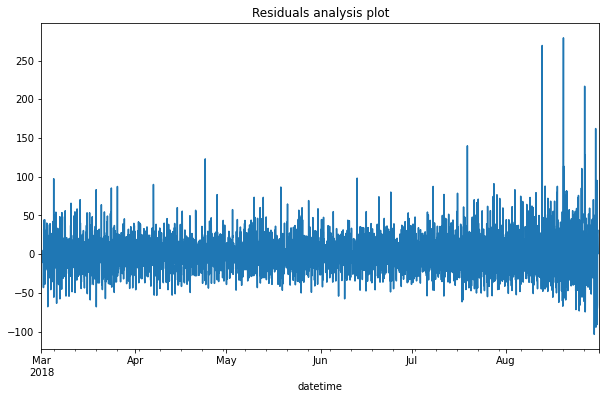

In [18]:
decomposed.resid.plot()
plt.title('Residuals analysis plot')
plt.show()

By analyzing the trend chart I conclude that during the year the average number of trips per hour is growing and the service is becoming more popular.

# Building the models

In [19]:
#random state
state = 42

In [20]:
results_table = pd.DataFrame(columns = ['model', 
                                        'RMSE train', 
                                        'RMSE test'])

In [21]:
def add_to_table(table, model, rmse_train, rmse_test):
    
    table = table.append(
        {'model': str(model), 
         'RMSE train': rmse_train, 
         'RMSE test': rmse_test},
    ignore_index = True)
    return(table)

**The constant model**

In this project I will use RMSE metric to evaluate the models performance and compare them.

To have an understanding whether the ML models actually provide valuable predicitons I will calculate RMSE for the constant model that simply always predicts the median value.

Due to time sensitive nature of the data I will dedicate 10% of the most recent events as a test set. This way the model won't be able to train on the future data and predict the past which would have happened if I randomly shuffled the data to the test set.

In [22]:
# 10% of data goes to test set

data = data.drop('rolling_mean', axis = 1)
train, test = train_test_split(data, test_size=0.1, shuffle=False)
print(train.shape)
print(test.shape)

(3974, 1)
(442, 1)


In [23]:
pred_median = np.ones(test.shape)
pred_median = pd.DataFrame(pred_median).replace(1, train['num_orders'].median())

rmse_constant_test = mean_squared_error(y_true = test['num_orders'], y_pred = pred_median)**0.5
print("RMSE test:", rmse_constant_test)

RMSE test: 87.15277582981295


In [24]:
results_table = add_to_table(results_table, 'constant_model', None, rmse_constant_test)

In [25]:
results_table

,model,RMSE train,RMSE test
0,constant_model,None,87.152776


**Make some features**

In order for the models to train and make predictions I will extract a number of basic features usually used with the time series forecasting. I will write a function that will allow me to tweak the parameteres so that I could compare different rolling mean sizes and lag size influence on the model performance.

In [26]:
def features_builder(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day # day of the month
    new_data['weekday'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [27]:
def data_preparation(data, max_lag, rolling_mean_size):
    new_data = features_builder(data, max_lag, rolling_mean_size)
    
    train, test = train_test_split(new_data, shuffle=False, test_size=0.2)
    train = train.dropna()

    y_train = train['num_orders']
    X_train = train.drop('num_orders', axis = 1)

    y_test = test['num_orders']
    X_test = test.drop('num_orders', axis = 1)
    
    return X_train, y_train, X_test, y_test

In [28]:
X_train, y_train, X_test, y_test = data_preparation(data, 10, 24)

## Linear regression

In [29]:
def linear_model(X, y, verbose=False):
    linear_model = LinearRegression()
    linear_model.fit(X, y)

    preds = linear_model.predict(X)

    rmse = mean_squared_error(preds, y)**0.5
    
    if verbose is True:
        print("RMSE:", rmse)
    return linear_model, rmse

In [30]:
lr, rmse_train = linear_model(X_train, y_train, verbose=True)

RMSE: 28.66919756616136


In [31]:
results_table = add_to_table(results_table, 'LinearRegression', rmse_train, None)

## Random Forest Regressor

Here for some practice I make a time series split cross validation algorithm.

Alternatively it could be done with gridsearchcv sklearn command

In [32]:
def rf_tsc_cross_val(X, y, n_estimators_range, depth_range, n_splits, random_state):
    best_score = 1000
    best_rfr_model = None
    
    for i in range(depth_range[0], depth_range[1], depth_range[2]):
        for x in range(n_estimators_range[0], n_estimators_range[1], n_estimators_range[2]):
            tscv = TimeSeriesSplit(n_splits=n_splits)       
            score = []

            for tr_index, val_index in tscv.split(X):
                X_tr, X_val = X.iloc[tr_index], X.iloc[val_index]
                y_tr, y_val = y.iloc[tr_index], y.iloc[val_index] 

                model = RandomForestRegressor(random_state = random_state, 
                                              n_estimators=x,
                                              max_depth = i)
                model.fit(X_tr, y_tr)
                predictions = model.predict(X_val)
                rmse = mean_squared_error(predictions, y_val)**0.5

                score.append(rmse)

            cross_val_score = np.mean(score)

            if cross_val_score < best_score:
                best_score = cross_val_score
                best_rfr_model = model
    print('Best RMSE is', best_score)
    print('Best n_estimators is', x)
    print('Best max_depth is', i)
    return best_rfr_model, best_score

In [33]:
rfr_model, rmse_train = rf_tsc_cross_val(X=X_train, 
                                         y=y_train, 
                                         n_estimators_range=(100,1001, 100), 
                                         depth_range=(2, 13, 2),
                                         n_splits=3,
                                         random_state=state)

Best RMSE is 29.136256121735798
Best n_estimators is 1000
Best max_depth is 12


In [34]:
results_table = add_to_table(results_table, 'RandomForestRegressor', rmse_train, None)

### LGBMRegressor

In [35]:
def lbgm_tsc_cross_val(X, y, n_estimators_range, depth_range, \
                       learning_rate_range, n_splits, random_state, \
                       colsample_bytree, verbose=False, **kwargs):
    best_score = 1000
    best_lgbm_model = None
    for d in range(depth_range[0], depth_range[1], depth_range[2]):
        for n in range(n_estimators_range[0], n_estimators_range[1], n_estimators_range[2]):
            for l in range(learning_rate_range[0], learning_rate_range[1], learning_rate_range[2]):
                for c in range(colsample_bytree[0], colsample_bytree[1], colsample_bytree[2]):
                    tscv = TimeSeriesSplit(n_splits=3)
                    score = []

                    for tr_index, val_index in tscv.split(X):
                        X_tr, X_val = X.iloc[tr_index], X.iloc[val_index]
                        y_tr, y_val = y.iloc[tr_index], y.iloc[val_index] 

                        model = LGBMRegressor(random_state = random_state, 
                                              learning_rate=l/100,
                                              max_depth=d,
                                              n_estimators=n,
                                              metric='RMSE',
                                              colsample_bytree=c/10)
                        model.fit(X_tr, y_tr)
                        predictions = model.predict(X_val)
                        rmse_test = mean_squared_error(predictions, y_val)**0.5

                        score.append(rmse_test)

                    cross_val_score = np.mean(score)
                    if cross_val_score < best_score:
                        best_score = cross_val_score
                        best_lgbm_model = model
    
    if verbose is True:
        print('Best RMSE is', round(best_score, 2))
        print('Best n_estimators is', n)
        print('Best max_depth is', d)
        print('Best learning rate is', round(l/100, 3))
        print('Best feature fraction is', round(c/10, 2))
    return best_lgbm_model, best_score

In [36]:
lgbm_model, rmse_train = lbgm_tsc_cross_val(X=X_train, 
                                            y=y_train, 
                                            n_estimators_range=(200, 401, 100), 
                                            depth_range=(2, 11, 2),
                                            learning_rate_range=(5, 51, 20),
                                            colsample_bytree=(6, 11, 2),
                                            n_splits=3,
                                            random_state=state,
                                            verbose=True)

Best RMSE is 29.61
Best n_estimators is 400
Best max_depth is 10
Best learning rate is 0.45
Best feature fraction is 1.0


In [37]:
results_table = add_to_table(results_table, 'LGBMRegressor', rmse_train, None)

In [38]:
results_table

,model,RMSE train,RMSE test
0,constant_model,None,87.152776
1,LinearRegression,28.669198,None
2,RandomForestRegressor,29.136256,None
3,LGBMRegressor,29.605315,None


# Testing the models

## Linear regression

In [39]:
def test_model(model, model_name, X=X_test, y=y_test, results_table=results_table):
    predictions = model.predict(X)
    rmse_test = mean_squared_error(y, predictions)**0.5
    results_table.loc[results_table['model']==model_name, ['RMSE test']] = rmse_test
    
    print("RMSE test:", rmse_test)
    return rmse_test

In [40]:
test_model(lr, 'LinearRegression')

RMSE test: 46.292155934844246


46.292155934844246

## Random Forest Regressor

In [46]:
test_model(rfr_model, 'RandomForestRegressor')

RMSE test: 52.882736519925544


52.882736519925544

In [47]:
results_table

,model,RMSE train,RMSE test
0,constant_model,None,87.152776
1,LinearRegression,28.669198,46.292156
2,RandomForestRegressor,29.136256,52.882737
3,LGBMRegressor,29.605315,None


## LGBM regressor

In [51]:
test_model(lgbm_model, 'LGBMRegressor')

RMSE test: 55.35216842424908


55.35216842424908

In [52]:
feature_importances = pd.DataFrame({'feature':list(X_train.columns),
                                    'importance':lgbm_model.feature_importances_})

feature_importances =\
feature_importances.sort_values('importance',ascending = False).reset_index(drop=True)
feature_importances

,feature,importance
0,lag_1,274
1,lag_5,220
2,lag_2,210
3,lag_8,206
4,lag_7,202
5,lag_6,181
6,lag_10,177
7,lag_3,159
8,lag_9,154
9,lag_4,133


# Results

In [53]:
results_table.sort_values(by='RMSE test')

,model,RMSE train,RMSE test
1,LinearRegression,28.669198,46.292156
2,RandomForestRegressor,29.136256,52.882737
3,LGBMRegressor,29.605315,55.352168
0,constant_model,None,87.152776


The best result in this project was achieved by the linear regression — most probably it managed to catch the rising trend in the data and used to to make predictions.

Random Forest and LGBM regressors show nearly similar results though still beating constant model.

# Experimenting with parameters

Let's wrap all feature engineering and parameter tuning for the models into one function

In [56]:
def parameter_tuning(max_lag, rolling_mean_size, model='Linear', params=None):
    
    best_lr_score = 1000
    best_lgbm_score = 1000
    best_lr_model = None
    best_lgbm_model = None
    best_lr_params = {key: None for key in ['max_lag', 'rolling_mean_size']}
    best_lgbm_params = {key: None for key in ['max_lag', 'rolling_mean_size']}

    for lag in range(max_lag[0], max_lag[1], max_lag[2]):
        for rolling_mean in range(rolling_mean_size[0], 
                                  rolling_mean_size[1], 
                                  rolling_mean_size[2]):
            X_train, y_train, X_test, y_test = data_preparation(data, lag, rolling_mean)
            
            if model == 'Linear':
            
                lr, lr_rmse_train = linear_model(X_train, y_train, verbose=False)
                if lr_rmse_train < best_lr_score:
                    best_lr_score = lr_rmse_train
                    best_lr_model = lr
                    best_lr_params['max_lag'] = lag
                    best_lr_params['rolling_mean_size'] = rolling_mean

            if model == 'LGBM':
                lgbm_model, lgbm_rmse_train = lbgm_tsc_cross_val(X_train, y_train, **params)
                if lgbm_rmse_train < best_lgbm_score:
                    best_lgbm_score = lgbm_rmse_train
                    best_lgbm_model = lgbm_model
                    best_lgbm_params['max_lag'] = lag
                    best_lgbm_params['rolling_mean_size'] = rolling_mean
    
    if model == 'Linear':
        print('Best RMSE is', best_lr_score)
        print('Best feature parameters are:', best_lr_params)
        return best_lr_model, best_lr_score, best_lr_params
    if model == 'LGBM':
        print('Best RMSE is', best_lgbm_score)
        print('Best feature parameters are:', best_lgbm_params)
        return best_lgbm_model, best_lgbm_score, best_lgbm_params

Let's test in with the Linear regression

In [57]:
feature_upd_lr, rmse_train, lr_params = parameter_tuning(max_lag=(10, 29, 3), 
                                                         rolling_mean_size=(10, 60, 15),
                                                         model='Linear')

Best RMSE is 23.881370968837892
Best feature parameters are: {'max_lag': 28, 'rolling_mean_size': 40}


In [58]:
results_table = add_to_table(results_table, 'Tuned_LR', rmse_train, None)

In [59]:
# searchable params for the LGBM model
params = {'n_estimators_range':(400,601, 100),
          'depth_range':(5, 15, 3),
          'learning_rate_range':(5, 51, 20),
          'colsample_bytree':(6, 11, 2),
          'n_splits':3,
          'random_state':state,
          'verbose':False}

In [60]:
feature_upd_lgbm, rmse_train, lgbm_params = parameter_tuning(max_lag=(10, 29, 3), 
                                                             rolling_mean_size=(10, 60, 15),
                                                             model='LGBM',
                                                             params=params)

Best RMSE is 24.527239273429288
Best feature parameters are: {'max_lag': 28, 'rolling_mean_size': 10}


In [61]:
results_table = add_to_table(results_table, 'Tuned_LGBMRegressor', rmse_train, None)

OK, features tunning seems to be giving the results!\
Let's test these models on the test set and see if they manage to outperform the first batch of models

In [73]:
# prepare features for this model
X_train, y_train, X_test, y_test = \
data_preparation(data, lr_params['max_lag'], lr_params['rolling_mean_size'])

test_model(feature_upd_lr, 'Tuned_LR', X=X_test, y=y_test, results_table=results_table)

RMSE test: 43.335648377893165


43.335648377893165

In [77]:
X_train, y_train, X_test, y_test = \
data_preparation(data, lgbm_params['max_lag'], lgbm_params['rolling_mean_size'])

test_model(feature_upd_lgbm, 'Tuned_LGBMRegressor', X=X_test, y=y_test, results_table=results_table)

RMSE test: 49.85358213283679


49.85358213283679

In [78]:
results_table.sort_values(by='RMSE test')

,model,RMSE train,RMSE test
4,Tuned_LR,23.881371,43.335648
1,LinearRegression,28.669198,46.292156
5,Tuned_LGBMRegressor,24.527239,49.853582
2,RandomForestRegressor,29.136256,52.882737
3,LGBMRegressor,29.605315,55.352168
0,constant_model,None,87.152776


# Feature experimenting results

By adjusting the rolling mean size and maximum time lag I have managed to improve Linear regression models RMSE by 3 — from 46.3 to 43.3 which is a significant improvement.

LGBM might not be the best suit for this kind of task as the training dataset is relatively small. Still some parameter and features tuning significantly improved the models performance — from 55.35 to 49.85 RMSE which is a big improvement.